In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
from models.model_fpgan import FPGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/epileptic/Epileptic_Seizure_Recognition.csv")
data = data.drop(columns=['Unnamed'])
data.loc[data["y"] > 1 , "y"] = 0
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [4]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data = data[:70000]

In [5]:
target = 'y'

In [6]:
X = data.drop(columns=[target])
y = data[target]

In [7]:
model_ctgan = FPGANSynthesizer(epochs=20, verbose=True)
original_losses, tranformed_privacies, losses = model_ctgan.fit(data)

Epoch 1, Loss G: -0.5798,Loss D: -3.2409
Epoch 2, Loss G: -0.8245,Loss D: -0.5748
Epoch 3, Loss G: -0.2112,Loss D: -0.4354
Epoch 4, Loss G:  0.4521,Loss D: -0.3741
Epoch 5, Loss G:  0.2726,Loss D: -2.3722
Epoch 6, Loss G: -0.4278,Loss D:  0.2403
Epoch 7, Loss G: -0.4530,Loss D:  0.0171
Epoch 8, Loss G: -0.4635,Loss D: -0.5954
Epoch 9, Loss G: -0.3731,Loss D: -0.2088
Epoch 10, Loss G: -0.2218,Loss D: -0.1420
Epoch 11, Loss G: -0.0799,Loss D: -0.1271
Epoch 12, Loss G: -0.0826,Loss D: -0.2514
Epoch 13, Loss G:  0.1041,Loss D: -1.3757
Epoch 14, Loss G:  0.0332,Loss D: -1.4381
Epoch 15, Loss G:  0.2453,Loss D: -2.1128
Epoch 16, Loss G: -0.1895,Loss D: -1.6004
Epoch 17, Loss G: -0.1869,Loss D: -3.6452
Epoch 18, Loss G:  0.1816,Loss D: -3.9199
Epoch 19, Loss G: -0.2698,Loss D: -5.4422
Epoch 20, Loss G: -0.0216,Loss D: -4.4208


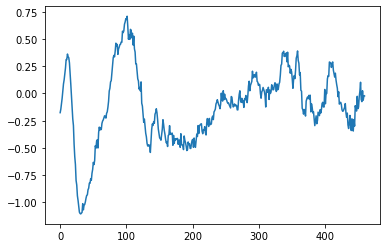

In [8]:
plt.plot(losses)
plt.show()

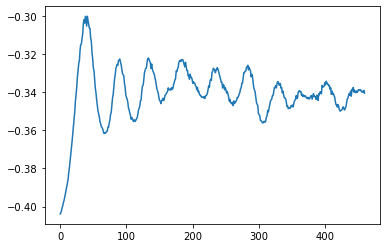

In [9]:
plt.plot(tranformed_privacies)
plt.show()

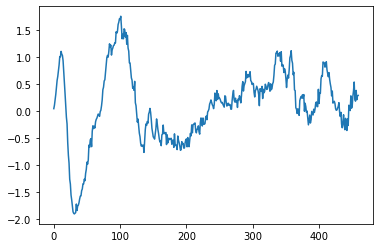

In [10]:
plt.plot(original_losses)
plt.show()

In [11]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [12]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [13]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.06445862]


## Fidelity

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test, undersample = True)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test, undersample = True)

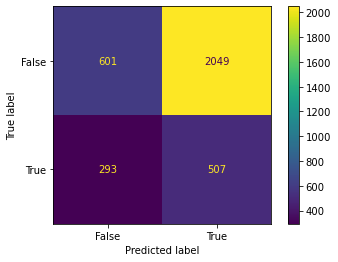

In [24]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [25]:
percentage, same_pred, dif_pred = eval_fidelity(rr_pred, fr_pred)

In [26]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.9339130434782609
Accuracy of synthetic data:  0.3136231884057971


In [27]:
print(same_pred, dif_pred)

1108 2342


## Final plot

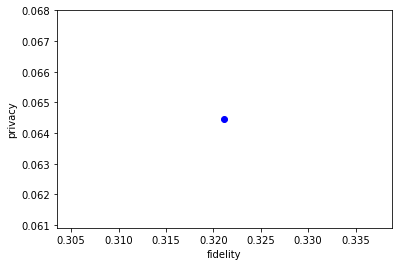

In [28]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()